In [2]:
import pandas as pd
import torch
import numpy as np
import pywt
import sys
import os
import matplotlib.pyplot as plt
from typing import Optional
from pydantic import BaseModel
from abc import ABC

# Adiciona o diretório raiz ao sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))

In [3]:
from ThreeWToolkit.feature_extraction import (
        extract_wavelet_features,
        extract_statistical_features,
        extract_exponential_statistics_features)

Sample DataFrame created. Shape: (200, 2)


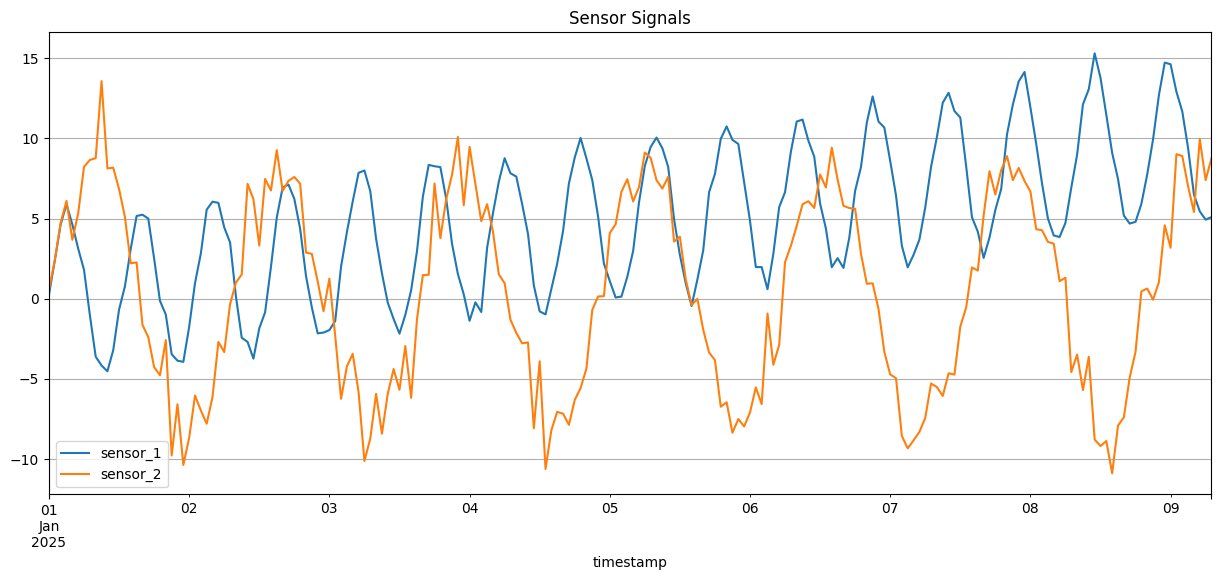

In [4]:
# Generate a time index
data_points = 200
time_index = pd.date_range(start='2025-01-01', periods=data_points, freq='h')

# Create sample signals
np.random.seed(42) # for reproductbility
time_vector = np.arange(data_points)

# Sensor 1: Linear trend + Sine wave + Noise
signal1 = 0.05 * time_vector + 5 * np.sin(time_vector * 0.5) + np.random.randn(data_points) * 0.5

# Sensor 2: Just a noisier Sine wave
signal2 = 8 * np.sin(time_vector * 0.2) + np.random.randn(data_points) * 1.5

# Create DataFrame
sample_df = pd.DataFrame(
    {'sensor_1': signal1, 'sensor_2': signal2},
    index=time_index
)
sample_df.index.name = 'timestamp'

# Plot the original signals
print("Sample DataFrame created. Shape:", sample_df.shape)
sample_df.plot(figsize=(15, 6), title='Sensor Signals', grid=True)
plt.show()

### Wavelet Feature Extraction

In [9]:
# Configure the extractor
config = extract_wavelet_features.WaveletConfig(level=3, overlap=0.875, offset=0)

# Instantiate the extractor
feature_extractor = extract_wavelet_features.ExtractWaveletFeatures(config)

# Apply it to our data
wavelet_features = feature_extractor(sample_df)

# Display the first few rows of the result
print("Shape of the extracted features:", wavelet_features.shape)
print("\nColumns are named as <sensor_name>_<feature>_<level>.")
print("Ex: sensor_1_A3 is the level 3 approximation coefficient for sensor 1.")

wavelet_features.head()

Shape of the extracted features: (193, 14)

Columns are named as <sensor_name>_<feature>_<level>.
Ex: sensor_1_A3 is the level 3 approximation coefficient for sensor 1.


,sensor_1_A3,sensor_2_A3,sensor_1_D3,sensor_2_D3,sensor_1_A2,sensor_2_A2,sensor_1_D2,sensor_2_D2,sensor_1_A1,sensor_2_A1,sensor_1_D1,sensor_2_D1,sensor_1_A0,sensor_2_A0
timestamp,,,,,,,,,,,,,,
2025-01-01 07:00:00,7.667248,14.030942,-1.635832,4.269348,4.264855,12.940259,-3.489848,3.942884,0.548013,11.938184,-1.990792,0.300811,-1.020199,8.654277
2025-01-01 08:00:00,6.300019,16.941563,-6.100933,4.962720,0.140775,15.488667,-4.779724,1.934771,-3.280232,12.320231,-1.837453,0.081235,-3.618750,8.769160
2025-01-01 09:00:00,3.986236,20.879917,-8.943135,6.854354,-3.505056,19.611090,-4.280064,2.727948,-5.504911,15.796086,-0.387226,3.394620,-4.166371,13.569878
2025-01-01 10:00:00,0.748561,22.078742,-10.175460,5.586125,-6.665825,19.562015,-2.026876,2.138578,-6.146668,15.344637,-0.254530,-3.846069,-4.526330,8.130715
2025-01-01 11:00:00,-2.472154,22.811827,-8.503570,4.511538,-7.761008,19.320537,0.024112,-3.018502,-5.470812,11.527279,0.930385,0.028712,-3.210567,8.171320


In [10]:
# Configure with an offset
config_offset = extract_wavelet_features.WaveletConfig(level=3, overlap=0.875, offset=20)
extractor_offset = extract_wavelet_features.ExtractWaveletFeatures(config_offset)
features_offset = extractor_offset(sample_df)

print("--- No offset ---")
print("Start index:", wavelet_features.index[0])

print("\n--- Using offset=20 ---")
print("Start index with offset:", features_offset.index[0])
print("Extraction began 20 points later, so the first timestamp is delayed.")

features_offset.head()

--- No offset ---
Start index: 2025-01-01 07:00:00

--- Using offset=20 ---
Start index with offset: 2025-01-02 03:00:00
Extraction began 20 points later, so the first timestamp is delayed.


,sensor_1_A3,sensor_2_A3,sensor_1_D3,sensor_2_D3,sensor_1_A2,sensor_2_A2,sensor_1_D2,sensor_2_D2,sensor_1_A1,sensor_2_A1,sensor_1_D1,sensor_2_D1,sensor_1_A0,sensor_2_A0
timestamp,,,,,,,,,,,,,,
2025-01-02 03:00:00,-1.645284,-20.786499,7.019935,-0.062639,3.800453,-14.742567,4.581657,-0.027384,5.927046,-10.443932,1.931415,-0.585142,5.556771,-7.798733
2025-01-02 04:00:00,0.843732,-22.038310,10.051849,2.995212,7.704339,-13.465504,3.905149,-0.456318,8.209148,-9.844215,0.350687,1.184860,6.052717,-6.123089
2025-01-02 05:00:00,4.181274,-19.536537,10.253219,2.855563,10.206728,-11.795230,1.824618,2.974720,8.507446,-6.237042,-0.052389,2.422313,5.978628,-2.697421
2025-01-02 06:00:00,7.121697,-18.386586,8.462019,4.279723,11.019351,-9.975058,-0.590137,3.946763,7.374568,-4.262648,-1.080489,-0.447919,4.450586,-3.330874
2025-01-02 07:00:00,9.755002,-14.840949,4.380351,6.008188,9.995204,-6.245705,-2.036142,2.574804,5.627907,-2.595719,-0.666172,2.114848,3.508477,-0.340027


### Statistical Feature Extraction

In [11]:
# Configure the statistical extractor
config_stats = extract_statistical_features.StatisticalConfig(window_size=20, overlap=0.75)

# Instantiate the extractor
statistical_extractor = extract_statistical_features.ExtractStatisticalFeatures(config_stats)

# Apply it to the same sample data
statistical_features = statistical_extractor(sample_df)

# Display the first few rows of the result
print(f"Shape of the extracted statistical features: {statistical_features.shape}")
print("\nThe columns contain the 9 statistical features extracted for each sensor.")

statistical_features.head()

Shape of the extracted statistical features: (37, 18)

The columns contain the 9 statistical features extracted for each sensor.


,sensor_1_mean,sensor_2_mean,sensor_1_std,sensor_2_std,sensor_1_skew,sensor_2_skew,sensor_1_kurt,sensor_2_kurt,sensor_1_min,sensor_2_min,sensor_1_1qrt,sensor_2_1qrt,sensor_1_med,sensor_2_med,sensor_1_3qrt,sensor_2_3qrt,sensor_1_max,sensor_2_max
timestamp,,,,,,,,,,,,,,,,,,
2025-01-01 19:00:00,1.357652,4.083537,3.301361,4.705588,-0.386824,-0.243456,1.903921,2.444523,-4.526330,-4.772052,-0.762122,1.789421,2.086601,4.920511,4.629858,8.140867,5.898990,13.569879
2025-01-02 00:00:00,-0.232122,1.310412,3.292996,7.039228,0.317458,-0.152326,1.737676,1.772178,-4.526330,-10.368602,-3.500713,-4.394170,-0.831689,2.237208,2.660554,8.140867,5.240376,13.569879
2025-01-02 05:00:00,1.031484,-2.398370,3.635780,5.783389,-0.051650,0.557139,1.573461,2.086306,-4.526330,-10.368602,-2.118934,-6.680374,0.871406,-3.482815,5.039384,2.222105,6.052717,8.171320
2025-01-02 10:00:00,1.406527,-3.619932,3.534455,4.343569,-0.143801,0.550867,1.501132,2.919283,-3.939635,-10.368602,-1.925738,-6.680374,1.740216,-3.799541,5.039384,-1.304680,6.052717,7.168823
2025-01-02 15:00:00,0.549360,-1.429729,3.505892,6.247898,0.269163,0.256675,1.594723,1.691908,-3.939635,-10.368602,-2.502265,-6.680374,-0.344252,-2.639926,3.744004,4.035415,6.052717,9.266996


One of the possible visualizations for statistical features is to plot the rolling mean with a standard deviation 'band' around it. This gives us an idea of the central tendency and the volatility of the signal over time.

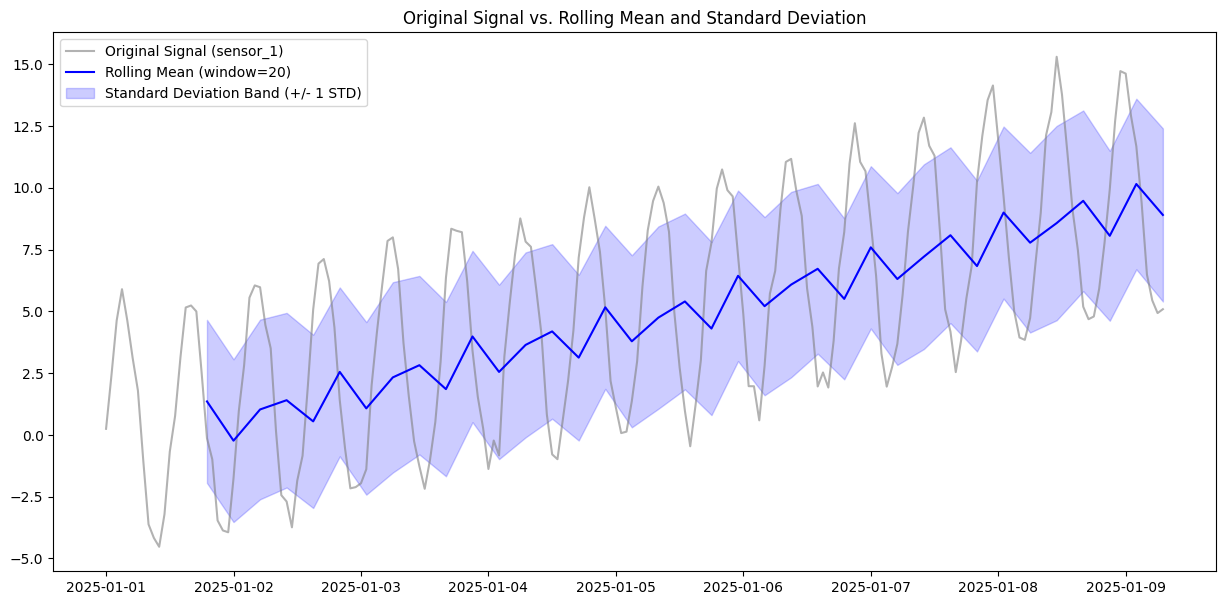

In [12]:
# Plotting the results for "sensor_1"
fig, ax = plt.subplots(figsize=(15, 7))

# Plot the original signal
ax.plot(sample_df.index, sample_df["sensor_1"], label="Original Signal (sensor_1)", color="gray", alpha=0.6)

# Plot the rolling mean
ax.plot(statistical_features.index, statistical_features["sensor_1_mean"], label="Rolling Mean (window=20)", color="blue")

# Create a shaded region for the standard deviation (mean +/- std)
ax.fill_between(
    statistical_features.index,
    statistical_features["sensor_1_mean"] - statistical_features["sensor_1_std"],
    statistical_features["sensor_1_mean"] + statistical_features["sensor_1_std"],
    color="blue",
    alpha=0.2,
    label="Standard Deviation Band (+/- 1 STD)"
)

ax.set_title("Original Signal vs. Rolling Mean and Standard Deviation")
ax.legend()
plt.show()

### Exponentially Weighted Statistical Feature Extraction

In [13]:
# Configuring the EWMA statistical extractor
# decay: A value between 0 and 1. A higher value gives more weight to more recent points.
# A decay of 0.9 means each data point has 90% of the weight of the next point in the window.
config_ew = extract_exponential_statistics_features.EWStatisticalConfig(window_size=20, overlap=0.75, decay=0.9)

ew_extractor = extract_exponential_statistics_features.ExtractEWStatisticalFeatures(config_ew)

ew_features = ew_extractor(sample_df)

# Display the first few rows of the result
print(f"Shape of the extracted EWMA features: {ew_features.shape}")
ew_features.head()

Shape of the extracted EWMA features: (37, 18)


,sensor_1_ew_mean,sensor_2_ew_mean,sensor_1_ew_std,sensor_2_ew_std,sensor_1_ew_skew,sensor_2_ew_skew,sensor_1_ew_kurt,sensor_2_ew_kurt,sensor_1_ew_min,sensor_2_ew_min,sensor_1_ew_1qrt,sensor_2_ew_1qrt,sensor_1_ew_med,sensor_2_ew_med,sensor_1_ew_3qrt,sensor_2_ew_3qrt,sensor_1_ew_max,sensor_2_ew_max
timestamp,,,,,,,,,,,,,,,,,,
2025-01-01 19:00:00,1.556875,2.282158,3.193338,5.273780,-0.447923,0.174277,2.023704,1.908622,-1.904967,-1.337600,-0.726198,-0.093431,0.165885,0.500277,0.962310,1.110912,1.359741,2.140347
2025-01-02 00:00:00,-0.617338,-2.522916,3.229513,6.646642,0.605310,0.635053,2.017331,2.270114,-1.210396,-1.180398,-0.892820,-0.281534,-0.066372,0.716170,1.014980,1.604386,1.813807,2.421191
2025-01-02 05:00:00,1.823505,-4.698268,3.731685,4.417987,-0.301585,1.283870,1.590288,4.358445,-1.701599,-1.283465,-1.056476,-0.448644,-0.255139,0.275115,0.861776,1.566408,1.133325,2.912997
2025-01-02 10:00:00,1.186155,-2.314675,3.504457,4.901954,0.026609,0.380378,1.454615,2.376807,-1.462648,-1.643003,-0.887981,-0.890604,0.158102,-0.302913,1.099522,0.206039,1.388678,1.934636
2025-01-02 15:00:00,0.786051,1.948918,3.364235,6.020947,0.189200,-0.525823,1.572265,1.933361,-1.404683,-2.045778,-0.977433,-1.433212,-0.335976,-0.762147,0.879234,0.346539,1.565486,1.215436


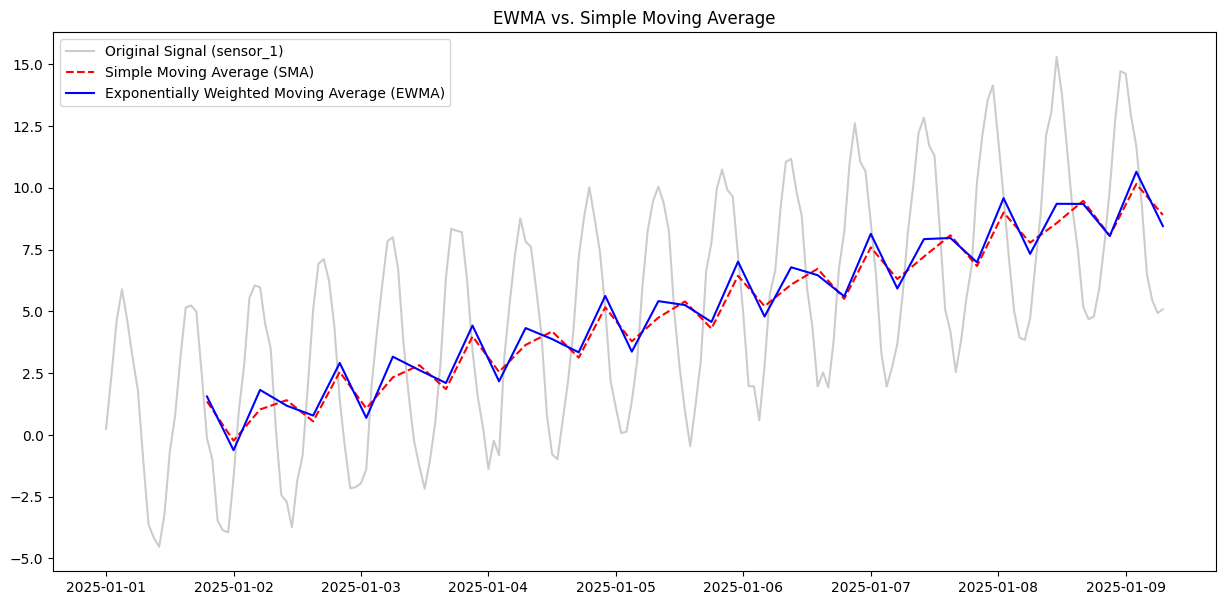

Notice how the blue line (EWMA) is more 'responsive' and follows the recent signal changes more closely than the red dashed line (SMA).


In [14]:
# Plotting the results for sensor_1
fig, ax = plt.subplots(figsize=(15, 7))

# Plot the original signal
ax.plot(sample_df.index, sample_df["sensor_1"], label="Original Signal (sensor_1)", color="gray", alpha=0.4)

# Plot the Simple Moving Average
ax.plot(statistical_features.index, statistical_features["sensor_1_mean"], label="Simple Moving Average (SMA)", color="red", linestyle="--")

# Plot the Exponentially Weighted Moving Average (EWMA)
ax.plot(ew_features.index, ew_features["sensor_1_ew_mean"], label="Exponentially Weighted Moving Average (EWMA)", color="blue")

ax.set_title("EWMA vs. Simple Moving Average")
ax.legend()
plt.show()

print("Notice how the blue line (EWMA) is more 'responsive' and follows the recent signal changes more closely than the red dashed line (SMA).")